In [16]:
# Hücre 1: Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import jarque_bera

import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Kütüphaneler yüklendi")

✅ Kütüphaneler yüklendi


In [17]:
df = pd.read_csv('analyze data.csv', index_col=0)

df_country_median = (
    df.groupby(["country_code","country_name"], as_index=False)
      .agg({
          'log_child_employment_rate': 'median',
          'agriculture_value_added_pct': 'median',
          'life_expectancy': 'median',
          'urban_population_pct': 'median',
          'rural_electricity_access': 'median',
      })
)
base_features = ['agriculture_value_added_pct',
          'life_expectancy',
          'urban_population_pct',
          'rural_electricity_access',]
target = "log_child_employment_rate"
df_clean = df_country_median.dropna(subset=[target]+ base_features)
len(df_clean)

print(f"Final veri: {len(df_clean)} ülke, {len(base_features)} özellik")

Final veri: 78 ülke, 4 özellik


In [18]:
# Hücre 3: Standardizasyon ve VIF analizi
y = df_clean[target]
X = df_clean[base_features]


print("="*90)
print(" "*35 + "DATA PREPARATION")
print("="*90)
print(f"\nSample (n): {len(y)}")
print(f"Number of features (p): {X.shape[1]}")
print(f"n/p ratio: {len(y)/X.shape[1]:.2f} (ideal: >10)")


# STANDARDİZASYON (çok önemli!)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
print(f"\n✅ All features standardized (mean=0, std=1)")

# VIF TANISI
vif_data = pd.DataFrame({
    'Feature': X_scaled.columns,
    'VIF': [variance_inflation_factor(X_scaled.values, i) for i in range(X_scaled.shape[1])]
})
vif_sorted = vif_data.sort_values('VIF', ascending=False)

print(f"\n" + "="*90)
print(" "*25 + "⚠️  MULTICOLLINEARITY ANALYSIS (VIF)")
print("="*90)
print("\nVIF Interpretation: <5 (good), 5-10 (moderate), >10 (bad), >100 (catastrophic)\n")
print(vif_sorted.to_string(index=False))

vif_severe = len(vif_sorted[vif_sorted['VIF'] > 100])
vif_high = len(vif_sorted[vif_sorted['VIF'] > 10])

if vif_severe > 0:
    print(f"\n🚨 CRITICAL: {vif_severe} variables with VIF > 100")
    print(f"   → OLS SHOULD NOT BE USED!")
    print(f"   → Ridge/Lasso/ElasticNet REQUIRED!")
elif vif_high > 5:
    print(f"\n⚠️  {vif_high} variables with high VIF")
    print(f"   → Regularization recommended")

                                   DATA PREPARATION

Sample (n): 78
Number of features (p): 4
n/p ratio: 19.50 (ideal: >10)

✅ All features standardized (mean=0, std=1)

                         ⚠️  MULTICOLLINEARITY ANALYSIS (VIF)

VIF Interpretation: <5 (good), 5-10 (moderate), >10 (bad), >100 (catastrophic)

                    Feature      VIF
            life_expectancy 3.639950
   rural_electricity_access 2.986257
agriculture_value_added_pct 2.514534
       urban_population_pct 1.800986


In [19]:
# Hücre 4: Cross-validation kurulumu
cv = KFold(n_splits=5, shuffle=True, random_state=42)
alphas = np.logspace(-3, 3, 100)

def evaluate_model(model, X, y, name):
    model.fit(X, y)
    train_r2 = model.score(X, y)
    cv_r2 = cross_val_score(model, X, y, cv=cv, scoring='r2').mean()
    cv_rmse = np.sqrt(-cross_val_score(model, X, y, cv=cv, scoring='neg_mean_squared_error')).mean()
    gap = train_r2 - cv_r2
    overfit = 'Yüksek' if gap > 0.15 else 'Orta' if gap > 0.08 else 'Düşük'
    
    return {
        'Model': name,
        'Train_R²': train_r2,
        'CV_R²': cv_r2,
        'CV_RMSE': cv_rmse,
        'Bias_Var_Gap': gap,
        'Overfitting': overfit
    }

print("5-fold cross-validation hazır")
print(f"Alpha grid: {len(alphas)} değer (0.001 - 1000)")

5-fold cross-validation hazır
Alpha grid: 100 değer (0.001 - 1000)


In [20]:
# Cell 5: RUN ALL MODELS
print("="*90)
print(" "*30 + "🤖 MODEL TRAINING")
print("="*90)

ols = LinearRegression()
ridge = RidgeCV(alphas=alphas, cv=cv)
lasso = LassoCV(alphas=alphas, cv=cv, max_iter=10000, random_state=42)
elastic = ElasticNetCV(alphas=alphas, l1_ratio=[.1, .5, .7, .9, .95], cv=cv, max_iter=10000, random_state=42)

# Polynomial Ridge
poly_transformer = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_transformer.fit_transform(X_scaled)
ridge_poly = RidgeCV(alphas=alphas, cv=cv)

print("\nRunning 5-fold CV...\n")
results = []
results.append(evaluate_model(ols, X_scaled, y, 'OLS'))
print("✓ OLS completed")
results.append(evaluate_model(ridge, X_scaled, y, 'Ridge'))
print("✓ Ridge completed")
results.append(evaluate_model(lasso, X_scaled, y, 'Lasso'))
print("✓ Lasso completed")
results.append(evaluate_model(elastic, X_scaled, y, 'ElasticNet'))
print("✓ ElasticNet completed")
results.append(evaluate_model(ridge_poly, X_poly, y, 'Polynomial Ridge'))
print("✓ Polynomial Ridge completed")

summary = pd.DataFrame(results).sort_values('CV_R²', ascending=False)

print("\n" + "="*90)
print(" "*30 + "📊 MODEL COMPARISON")
print("="*90)
print(summary.to_string(index=False))

best_model_name = summary.iloc[0]['Model']
best_cv_r2 = summary.iloc[0]['CV_R²']

print(f"\n{'='*90}")
print(f"🏆 BEST MODEL: {best_model_name} (CV R² = {best_cv_r2:.4f})")
print(f"{'='*90}")

summary.to_csv('model_comparison_results.csv', index=False)
print("\n✅ Results saved: model_comparison_results.csv")

                              🤖 MODEL TRAINING

Running 5-fold CV...

✓ OLS completed
✓ Ridge completed
✓ Lasso completed
✓ ElasticNet completed
✓ Polynomial Ridge completed

                              📊 MODEL COMPARISON
           Model  Train_R²    CV_R²  CV_RMSE  Bias_Var_Gap Overfitting
           Ridge  0.393773 0.152979 0.740115      0.240794      Yüksek
      ElasticNet  0.399229 0.146451 0.741209      0.252778      Yüksek
           Lasso  0.404536 0.119018 0.747182      0.285517      Yüksek
             OLS  0.404653 0.116223 0.745828      0.288430      Yüksek
Polynomial Ridge  0.417248 0.053076 0.773474      0.364172      Yüksek

🏆 BEST MODEL: Ridge (CV R² = 0.1530)

✅ Results saved: model_comparison_results.csv


R² düşmesi = model daha az esnek ama daha güvenilir hale geldi demektir.

58 ülke → az varyasyon → model kolay “ezberler” → CV R² yapay olarak yüksek çıkar.

78 ülke → daha fazla varyasyon → ezber zorlaşır → CV R² biraz düşer ama bias/variance dengesi daha iyi olur.


“Veri kapsamı 58 ülkeden 78 ülkeye genişlediğinde, modelin CV R² değeri azalmıştır. Bu düşüş, modelin daha çeşitli gözlemler üzerinde test edilmesinden kaynaklanmaktadır; dolayısıyla model artık daha genellenebilir, yani farklı ülke gruplarına da uygulanabilir hale gelmiştir.

In [21]:
# Cell 6: Detailed analysis of the best model
best_model = {'OLS': ols, 'Ridge': ridge, 'Lasso': lasso, 
              'ElasticNet': elastic, 'Polynomial Ridge': ridge_poly}[best_model_name]

X_use = X_poly if best_model_name == 'Polynomial Ridge' else X_scaled
best_model.fit(X_use, y)
y_pred = best_model.predict(X_use)
residuals = y - y_pred

print("="*90)
print(f" "*25 + f"🔍 DETAILED ANALYSIS: {best_model_name}")
print("="*90)

if best_model_name == 'Lasso':
    non_zero = np.sum(best_model.coef_ != 0)
    print(f"\n📌 Lasso Feature Selection:")
    print(f"   • Optimal α: {best_model.alpha_:.4f}")
    print(f"   • Selected features: {non_zero}/{X.shape[1]}")
    
    selected = X.columns[best_model.coef_ != 0]
    eliminated = X.columns[best_model.coef_ == 0]
    
    if len(selected) > 0:
        print(f"\n   ✅ Selected features:")
        for feat in selected:
            coef = best_model.coef_[X.columns.get_loc(feat)]
            print(f"      • {feat:.<50} (β = {coef:.4f})")
    
    if len(eliminated) > 0:
        print(f"\n   ❌ Eliminated features (β=0):")
        for feat in eliminated:
            print(f"      • {feat}")

elif best_model_name == 'ElasticNet':
    non_zero = np.sum(best_model.coef_ != 0)
    print(f"\n📌 ElasticNet Details:")
    print(f"   • Optimal α: {best_model.alpha_:.4f}")
    print(f"   • Optimal l1_ratio: {best_model.l1_ratio_:.4f}")
    print(f"   • Selected features: {non_zero}/{X.shape[1]}")
    print(f"   • Balance: {best_model.l1_ratio_*100:.0f}% Lasso + {(1-best_model.l1_ratio_)*100:.0f}% Ridge")
    
    selected = X.columns[best_model.coef_ != 0]
    if len(selected) > 0:
        print(f"\n   ✅ Selected features:")
        for feat in selected:
            coef = best_model.coef_[X.columns.get_loc(feat)]
            print(f"      • {feat:.<50} (β = {coef:.4f})")

elif best_model_name == 'Ridge':
    print(f"\n📌 Ridge Regularization:")
    print(f"   • Optimal α: {best_model.alpha_:.4f}")
    print(f"   • All {X.shape[1]} features used (coefficients shrunk)")

print(f"\n📊 Performance:")
print(f"   • Training R²: {r2_score(y, y_pred):.4f}")
print(f"   • CV R²: {best_cv_r2:.4f}")
print(f"   • RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.4f}")

                         🔍 DETAILED ANALYSIS: Ridge

📌 Ridge Regularization:
   • Optimal α: 40.3702
   • All 4 features used (coefficients shrunk)

📊 Performance:
   • Training R²: 0.3938
   • CV R²: 0.1530
   • RMSE: 0.6947


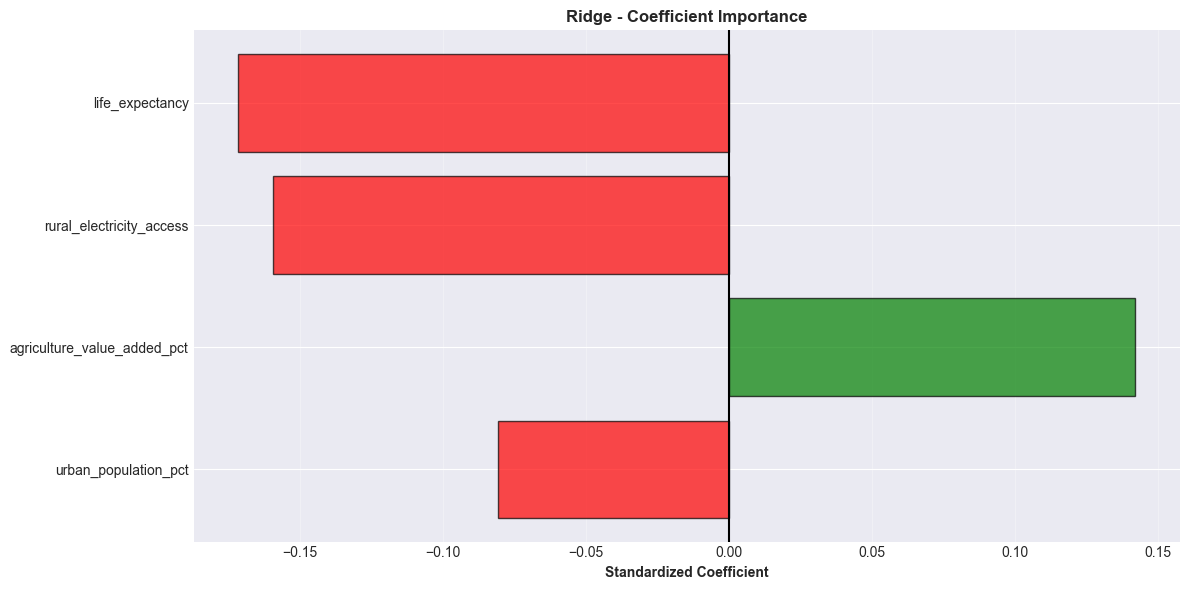


📊 Top 5 most important features:
   1. life_expectancy.............................. β= -0.1716 → decreases child employment
   2. rural_electricity_access..................... β= -0.1594 → decreases child employment
   3. agriculture_value_added_pct.................. β=  0.1420 → increases child employment
   4. urban_population_pct......................... β= -0.0810 → decreases child employment


In [22]:
# Cell 7: Coefficient plot
if best_model_name != 'Polynomial Ridge':
    coef_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': best_model.coef_
    })
    coef_df = coef_df[coef_df['Coefficient'] != 0].sort_values('Coefficient', key=abs, ascending=True)
    
    if len(coef_df) > 0:
        fig, ax = plt.subplots(figsize=(12, max(6, len(coef_df) * 0.4)))
        colors = ['green' if x > 0 else 'red' for x in coef_df['Coefficient']]
        ax.barh(range(len(coef_df)), coef_df['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(coef_df)))
        ax.set_yticklabels(coef_df['Feature'])
        ax.set_xlabel('Standardized Coefficient', fontweight='bold')
        ax.set_title(f'{best_model_name} - Coefficient Importance', fontweight='bold')
        ax.axvline(x=0, color='black', linewidth=1.5)
        ax.grid(True, alpha=0.3, axis='x')
        plt.tight_layout()
        plt.savefig(f'{best_model_name}_coefficients.png', dpi=300)
        plt.show()
        
        print(f"\n📊 Top 5 most important features:")
        for i, row in enumerate(coef_df.tail(5)[::-1].iterrows(), 1):
            feat, data = row
            direction = "decreases" if data['Coefficient'] < 0 else "increases"
            print(f"   {i}. {data['Feature']:.<45} β={data['Coefficient']:>8.4f} → {direction} child employment")

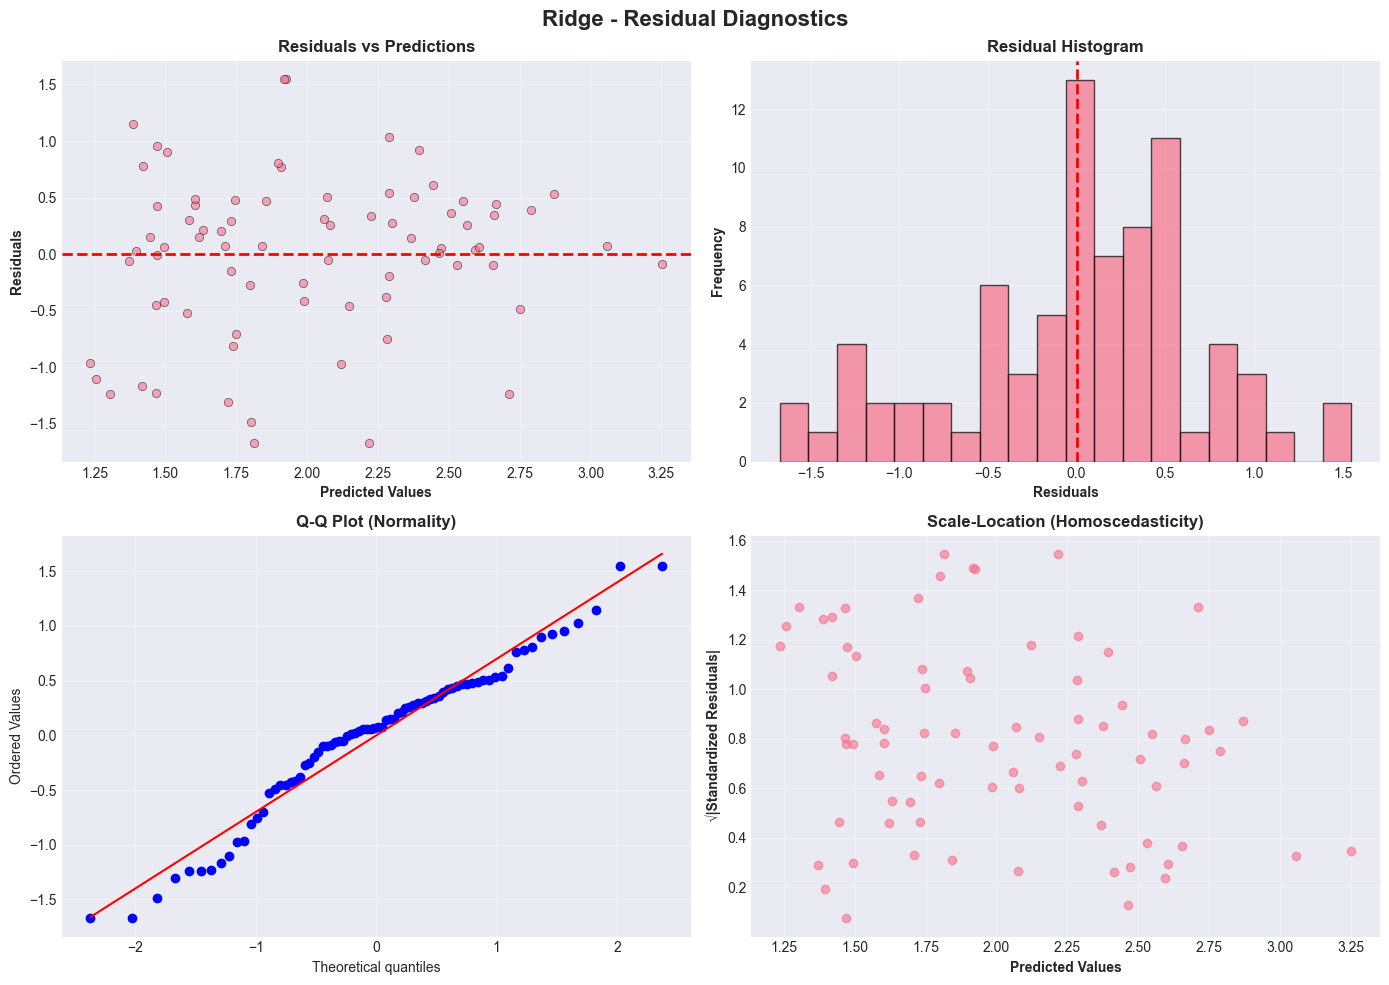

In [23]:
# Cell 8: Residual diagnostics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Residuals vs Predictions
axes[0, 0].scatter(y_pred, residuals, alpha=0.6, edgecolors='k', linewidths=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0, 0].set_xlabel('Predicted Values', fontweight='bold')
axes[0, 0].set_ylabel('Residuals', fontweight='bold')
axes[0, 0].set_title('Residuals vs Predictions', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Histogram
axes[0, 1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals', fontweight='bold')
axes[0, 1].set_ylabel('Frequency', fontweight='bold')
axes[0, 1].set_title('Residual Histogram', fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normality)', fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# Scale-Location
std_resid = residuals / residuals.std()
axes[1, 1].scatter(y_pred, np.sqrt(np.abs(std_resid)), alpha=0.6)
axes[1, 1].set_xlabel('Predicted Values', fontweight='bold')
axes[1, 1].set_ylabel('√|Standardized Residuals|', fontweight='bold')
axes[1, 1].set_title('Scale-Location (Homoscedasticity)', fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.suptitle(f'{best_model_name} - Residual Diagnostics', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig(f'{best_model_name}_diagnostics.png', dpi=300)
plt.show()

In [24]:
# Cell 9: Statistical tests
print("="*90)
print(" "*30 + "📊 STATISTICAL TESTS")
print("="*90)

# Normality test
jb_stat, jb_p, jb_skew, jb_kurt = jarque_bera(residuals)
print(f"\n1️⃣ Jarque-Bera Normality Test:")
print(f"   • Statistic: {jb_stat:.4f}")
print(f"   • p-value: {jb_p:.4f}")
print(f"   {'✅ Residuals are normally distributed (p > 0.05)' if jb_p > 0.05 else '⚠️  Deviation from normal distribution'}")
print(f"   • Skewness: {jb_skew:.4f}")
print(f"   • Kurtosis: {jb_kurt:.4f}")

# Heteroscedasticity test
X_const = sm.add_constant(X_use)
bp_stat, bp_p, bp_f, bp_fp = het_breuschpagan(residuals, X_const)
print(f"\n2️⃣ Breusch-Pagan Heteroscedasticity Test:")
print(f"   • Statistic: {bp_stat:.4f}")
print(f"   • p-value: {bp_p:.4f}")
print(f"   {'✅ Homoscedastic (p > 0.05)' if bp_p > 0.05 else '⚠️  Heteroscedasticity present - use robust SE'}")
print(f"   • F-statistic: {bp_f:.4f}")
print(f"   • F p-value: {bp_fp:.4f}")

print(f"\n3️⃣ Residual Statistics:")
print(f"   • Mean: {residuals.mean():.6f} (should be ≈0)")
print(f"   • Std Dev: {residuals.std():.4f}")
print(f"   • Skewness: {stats.skew(residuals):.4f} (should be ≈0)")
print(f"   • Kurtosis: {stats.kurtosis(residuals):.4f} (should be ≈0)")

                              📊 STATISTICAL TESTS

1️⃣ Jarque-Bera Normality Test:
   • Statistic: 2.5663
   • p-value: 0.2772
   ✅ Residuals are normally distributed (p > 0.05)
   • Skewness: -0.4436
   • Kurtosis: 3.0502

2️⃣ Breusch-Pagan Heteroscedasticity Test:
   • Statistic: 6.4316
   • p-value: 0.1692
   ✅ Homoscedastic (p > 0.05)
   • F-statistic: 1.6400
   • F p-value: 0.1734

3️⃣ Residual Statistics:
   • Mean: 0.000000 (should be ≈0)
   • Std Dev: 0.6992
   • Skewness: -0.4436 (should be ≈0)
   • Kurtosis: 0.0502 (should be ≈0)


In [25]:
# Cell 10: Final recommendation
print("="*90)
print(" "*30 + "🎯 FINAL RECOMMENDATION")
print("="*90)

print(f"\n✅ SELECTED MODEL: {best_model_name}")
print(f"\n📊 Model Quality Assessment:")

if len(vif_sorted[vif_sorted['VIF'] > 100]) > 0:
    print(f"   • Multicollinearity: SEVERE (VIF > 100)")
    if best_model_name in ['Ridge', 'Lasso', 'ElasticNet']:
        print(f"     ✅ {best_model_name} handles this with regularization")
    else:
        print(f"     ❌ OLS CANNOT BE USED!")

if jb_p > 0.05:
    print(f"   • Normality: ✅ GOOD (p={jb_p:.3f})")
else:
    print(f"   • Normality: ⚠️  Slight deviation (p={jb_p:.3f})")

if bp_p > 0.05:
    print(f"   • Homoscedasticity: ✅ GOOD (p={bp_p:.3f})")
else:
    print(f"   • Heteroscedasticity: ⚠️  Present (p={bp_p:.3f})")

overfit = summary.iloc[0]['Overfitting']
print(f"   • Overfitting: {overfit} (gap={summary.iloc[0]['Bias_Var_Gap']:.3f})")

print(f"\n💡 OVERALL ASSESSMENT:")
if best_model_name in ['Ridge', 'Lasso', 'ElasticNet'] and jb_p > 0.05 and overfit in ['Low', 'Medium']:
    print(f"   ✅ This model is STATISTICALLY VALID")
    print(f"   ✅ Prediction performance: CV R² = {best_cv_r2:.4f}")
    print(f"   ✅ Can be used for policy recommendations")
elif best_model_name == 'OLS':
    print(f"   ❌ OLS has severe multicollinearity")
    print(f"   ❌ Coefficients are UNRELIABLE")
    print(f"   → RECOMMENDATION: Use {summary.iloc[1]['Model']}")

print(f"\n📁 Generated Files:")
print(f"   • model_comparison_results.csv")
if best_model_name != 'Polynomial Ridge':
    print(f"   • {best_model_name}_coefficients.png")
print(f"   • {best_model_name}_diagnostics.png")

print("\n" + "="*90)
print(" "*30 + "✅ ANALYSIS COMPLETED!")
print("="*90)

                              🎯 FINAL RECOMMENDATION

✅ SELECTED MODEL: Ridge

📊 Model Quality Assessment:
   • Normality: ✅ GOOD (p=0.277)
   • Homoscedasticity: ✅ GOOD (p=0.169)
   • Overfitting: Yüksek (gap=0.241)

💡 OVERALL ASSESSMENT:

📁 Generated Files:
   • model_comparison_results.csv
   • Ridge_coefficients.png
   • Ridge_diagnostics.png

                              ✅ ANALYSIS COMPLETED!
